<a href="https://colab.research.google.com/github/amirkasaei/Deep-Neural-Network-tensorflow/blob/main/Deep_Neural_Network_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Libraries & Constants***

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy

# ***Preprocessing***

Reading & displaying data:

In [2]:
url = 'https://raw.githubusercontent.com/amirkasaei/Deep-Neural-Network-tensorflow/main/Dataset/Dataset.csv'

In [3]:
df = pd.read_csv(url)
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [4]:
print(df.shape)

(480, 17)


In [5]:
categorical_attr = ['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID', 'SectionID', 'Topic', 'Semester', 'Relation', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays', 'Class']

In [6]:
# Converting Categorical values to scaler values
le = LabelEncoder()
df[categorical_attr] = df[categorical_attr].apply(le.fit_transform, axis=0)

In [7]:
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,1,4,4,2,1,0,7,0,0,15,16,2,20,1,1,1,2
1,1,4,4,2,1,0,7,0,0,20,20,3,25,1,1,1,2
2,1,4,4,2,1,0,7,0,0,10,7,0,30,0,0,0,1
3,1,4,4,2,1,0,7,0,0,30,25,5,35,0,0,0,1
4,1,4,4,2,1,0,7,0,0,40,50,12,50,0,0,0,2


In [8]:
# X: Features, y: Classes
X = np.array(df.iloc[:, :-1])
y = np.array(df['Class'])

# reshapee y
y = y.reshape(480, 1)
print(y.shape)

(480, 1)


In [9]:
#change output into 3 class

# [L, M, H] = [1, 2, 0]
y = np.where(y is None, [0, 0, 0], y)
for i in range(len(y)):
  if y[i][0] == 0:
    y[i] = [0, 0, 1]
  elif y[i][0] == 1:
    y[i] = [1, 0, 0]
  elif y[i][0] == 2:
    y[i] = [0, 1, 0]


print(y.shape)


(480, 3)


In [10]:
# Deviding Dataset to training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

In [11]:
print('Number of dataset: ', len(X))
print('Number of train set: ', len(X_train))
print('Number of validation set: ', len(X_test))

Number of dataset:  480
Number of train set:  384
Number of validation set:  96


# ***Implementing Model***

## **Helper Functions**

In [12]:
def filter_prediction(a): # filtering y_pred to arrays of 0 and 1 according to softmax
  z = np.zeros(a.shape)
  z[np.arange(len(a)), a.argmax(1)] = 1 
  return z

def K_fold_cross_val(x, y, k, model_type, activation, optimizer, layer):

  # loss and accuracy in each fold
  accuracy_per_fold, loss_per_fold = [], []

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(x, y):

    # Define the model 
    if model_type == "simple":
      model = NN(activation, optimizer, layer, dropout=False, batch_norm=False)
    elif model_type == "dropout":
      model = NN(activation, optimizer, layer, dropout=True, batch_norm=False)
    elif model_type == "batch_norm":
      model = NN(activation, optimizer, layer, dropout=False, batch_norm=True)
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.model.fit(x[train], y[train], batch_size=64, epochs=100, verbose=0)

    # Generate generalization metrics
    scores = model.model.evaluate(x[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: loss = {scores[0]} ------ accuuracy = {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

    #model prediction
    model.report(x[test], y[test])


## **Neural Network**

In [17]:
class NN:
  def __init__(self, activation, optimizer, layer, dropout=False, batch_norm=False):
    # create sequential model
    self.model = Sequential()

    # add input layer
    self.model.add(Input(X.shape[1]))

    # adding hidden layers
    for i in range(1, layer):
        self.model.add(Dense(2**(layer+2-i), activation=activation))
        if dropout: # add dropout layer
          if 2**(layer+2-i) >= 32: # dropout rate 0.2 for layers with more than 32 neurons
            self.model.add(Dropout(0.2))
          elif 8 < 2**(layer+2-i) < 32:# dropout rate 0.1 for layers with less than 32 and more than 8 neurons
            self.model.add(Dropout(0.1))
        elif batch_norm:
          self.model.add(BatchNormalization())


    # output layer
    self.model.add(Dense(y.shape[1], activation="softmax"))  

    #set loss functon
    loss = CategoricalCrossentropy()

    # compiling created model
    self.model.compile(optimizer, loss, "accuracy")

  def train(self, X_train, y_train, X_test, y_test, batch_size=64, epochs=100):
    # train model
    self.history = self.model.fit(X_train, y_train, batch_size, epochs, shuffle=True, verbose=2, validation_data=(X_test, y_test)).history

    # best accuracy and loss in train and validation sets
    best_train_acc_index = self.history["accuracy"].index(max(self.history["accuracy"]))
    best_train_loss_index = self.history["loss"].index(min(self.history["loss"]))
    best_val_acc_index = self.history["val_accuracy"].index(max(self.history["val_accuracy"]))
    best_val_loss_index = self.history["val_loss"].index(min(self.history["val_loss"]))

    # printing results
    print("-----------------------------------------------------------------------------------------")
    print("\n best train model due to min loss: ", "loss= ", self.history["loss"][best_train_loss_index], "-------- accuracy= ", self.history["accuracy"][best_train_loss_index])
    print("\n best train model due to max accuracy: ", "loss= ", self.history["loss"][best_train_acc_index], "-------- accuracy= ", self.history["accuracy"][best_train_acc_index])
    print("\n best validation model due to min loss: ", "loss= ", self.history["val_loss"][best_val_loss_index], "-------- accuracy= ", self.history["val_accuracy"][best_val_loss_index])
    print("\n best validation model due to max accuracy: ", "loss= ", self.history["val_loss"][best_val_acc_index], "-------- accuracy= ", self.history["val_accuracy"][best_val_acc_index], "\n\n")
          
    return self.history

  def report(self, x, y): # calculate confusion metrix and classification report(precision, recall, f1-score)
    # calculate y_pred with given set
    y_pred = self.model.predict(x)
    
    # filter y_pred
    y_pred = filter_prediction(y_pred)

    # calculate and print classification report
    print(confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1)))
    report = classification_report(y, y_pred, target_names = ["Low", "Medium", "High"])
    print(report)

  def print_report(self, X_train, y_train, X_test, y_test):
    # training set evaluation (confusion metrics, precision, recall, f1-score)
    print("---------------------------- training set evaluation ----------------------")
    self.report(X_train, y_train)
    print("---------------------------------------------------------------------------")

    # teset set evaluation (confusion metrics, precision, recall, f1-score)
    print("---------------------------- test set evaluation --------------------------")
    self.report(X_test, y_test)
    print("---------------------------------------------------------------------------")

  def draw_plot(self, a, b, l): # draw training and validation accuracy or loss plots
    plt.plot(a, label = "training "+l)

    plt.plot(b, label = "validation "+l)

    # naming the x axis
    plt.xlabel("epoch")
    # naming the y axis
    plt.ylabel(l)
    # giving a title to my graph
    plt.title("Training & validation " + l)
    # show a legend on the plot
    plt.legend() 
    # function to show the plot
    plt.show()

  def draw_plots(self):
    # accuracy plot for both train and validiation sets
    self.draw_plot(self.history["accuracy"], self.history["val_accuracy"], "accuracy")

    # loss plot for both train and validiation sets
    self.draw_plot(self.history["loss"], self.history["val_loss"], "loss")


# **Simple Models**

## ***Simple Model***
**4 layered sigmoid Adam**

Epoch 1/100
6/6 - 1s - loss: 1.0769 - accuracy: 0.4557 - val_loss: 1.1018 - val_accuracy: 0.3750 - 549ms/epoch - 91ms/step
Epoch 2/100
6/6 - 0s - loss: 1.0532 - accuracy: 0.4557 - val_loss: 1.1014 - val_accuracy: 0.3750 - 30ms/epoch - 5ms/step
Epoch 3/100
6/6 - 0s - loss: 1.0258 - accuracy: 0.4557 - val_loss: 1.0459 - val_accuracy: 0.3750 - 32ms/epoch - 5ms/step
Epoch 4/100
6/6 - 0s - loss: 0.9840 - accuracy: 0.4557 - val_loss: 0.9913 - val_accuracy: 0.3750 - 31ms/epoch - 5ms/step
Epoch 5/100
6/6 - 0s - loss: 0.9339 - accuracy: 0.5495 - val_loss: 0.9470 - val_accuracy: 0.4583 - 32ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.8823 - accuracy: 0.5859 - val_loss: 0.9150 - val_accuracy: 0.4375 - 33ms/epoch - 5ms/step
Epoch 7/100
6/6 - 0s - loss: 0.8313 - accuracy: 0.5911 - val_loss: 0.8885 - val_accuracy: 0.4375 - 39ms/epoch - 6ms/step
Epoch 8/100
6/6 - 0s - loss: 0.7930 - accuracy: 0.6016 - val_loss: 0.8705 - val_accuracy: 0.4375 - 30ms/epoch - 5ms/step
Epoch 9/100
6/6 - 0s - loss: 0

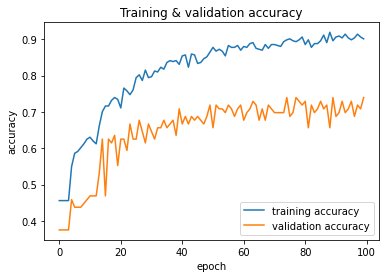

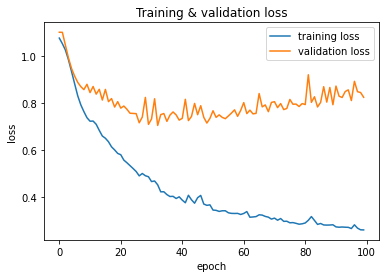

In [18]:
simple_model_1 = NN("sigmoid", Adam(InverseTimeDecay(0.01, 300, 0.9)), layer=4, dropout=False, batch_norm=False)

simple_model_1.train(X_train, y_train, X_test, y_test)

simple_model_1.print_report(X_train, y_train, X_test, y_test)

simple_model_1.draw_plots()

## ***Simple Model***
**4 layered sigmoid RMSprop**

Epoch 1/100
6/6 - 1s - loss: 1.0738 - accuracy: 0.4557 - val_loss: 1.0833 - val_accuracy: 0.4062 - 895ms/epoch - 149ms/step
Epoch 2/100
6/6 - 0s - loss: 0.9838 - accuracy: 0.5156 - val_loss: 1.0145 - val_accuracy: 0.4583 - 30ms/epoch - 5ms/step
Epoch 3/100
6/6 - 0s - loss: 0.9184 - accuracy: 0.5755 - val_loss: 0.9717 - val_accuracy: 0.4271 - 27ms/epoch - 5ms/step
Epoch 4/100
6/6 - 0s - loss: 0.8729 - accuracy: 0.5859 - val_loss: 0.9253 - val_accuracy: 0.4479 - 26ms/epoch - 4ms/step
Epoch 5/100
6/6 - 0s - loss: 0.8386 - accuracy: 0.5677 - val_loss: 0.9085 - val_accuracy: 0.4792 - 30ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.8011 - accuracy: 0.5938 - val_loss: 0.8966 - val_accuracy: 0.4479 - 35ms/epoch - 6ms/step
Epoch 7/100
6/6 - 0s - loss: 0.7857 - accuracy: 0.6042 - val_loss: 0.8915 - val_accuracy: 0.4583 - 27ms/epoch - 4ms/step
Epoch 8/100
6/6 - 0s - loss: 0.7555 - accuracy: 0.6120 - val_loss: 0.8647 - val_accuracy: 0.4896 - 27ms/epoch - 4ms/step
Epoch 9/100
6/6 - 0s - loss: 

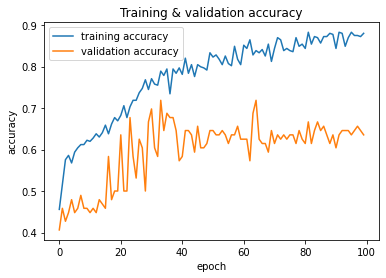

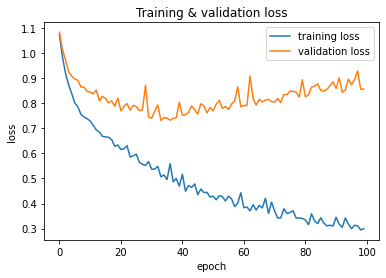

In [19]:
simple_model_2 = NN("sigmoid", RMSprop(InverseTimeDecay(0.01, 300, 0.9)), layer=4, dropout=False, batch_norm=False)

simple_model_2.train(X_train, y_train, X_test, y_test)

simple_model_2.print_report(X_train, y_train, X_test, y_test)

simple_model_2.draw_plots()

## ***Simple Model***
**4 layered relu Nadam**

Epoch 1/100
6/6 - 2s - loss: 1.6648 - accuracy: 0.4193 - val_loss: 1.0659 - val_accuracy: 0.3854 - 2s/epoch - 362ms/step
Epoch 2/100
6/6 - 0s - loss: 1.0016 - accuracy: 0.5286 - val_loss: 0.9324 - val_accuracy: 0.5312 - 121ms/epoch - 20ms/step
Epoch 3/100
6/6 - 0s - loss: 0.8976 - accuracy: 0.5469 - val_loss: 0.9052 - val_accuracy: 0.4688 - 47ms/epoch - 8ms/step
Epoch 4/100
6/6 - 0s - loss: 0.8402 - accuracy: 0.5729 - val_loss: 1.6178 - val_accuracy: 0.4271 - 72ms/epoch - 12ms/step
Epoch 5/100
6/6 - 0s - loss: 1.2155 - accuracy: 0.4661 - val_loss: 0.8258 - val_accuracy: 0.6458 - 81ms/epoch - 14ms/step
Epoch 6/100
6/6 - 0s - loss: 0.8052 - accuracy: 0.6016 - val_loss: 0.8336 - val_accuracy: 0.4896 - 41ms/epoch - 7ms/step
Epoch 7/100
6/6 - 0s - loss: 0.7793 - accuracy: 0.6042 - val_loss: 0.8644 - val_accuracy: 0.4688 - 39ms/epoch - 6ms/step
Epoch 8/100
6/6 - 0s - loss: 0.7803 - accuracy: 0.5859 - val_loss: 0.8154 - val_accuracy: 0.4896 - 63ms/epoch - 10ms/step
Epoch 9/100
6/6 - 0s - loss

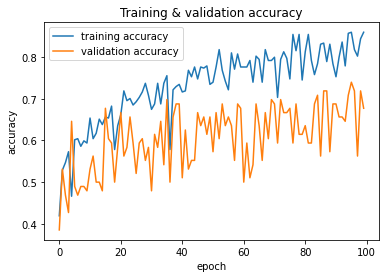

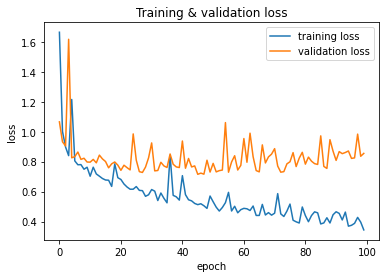

In [20]:
simple_model_3 = NN("relu", Nadam(0.01), layer=4, dropout=False, batch_norm=False)

simple_model_3.train(X_train, y_train, X_test, y_test)

simple_model_3.print_report(X_train, y_train, X_test, y_test)

simple_model_3.draw_plots()

## ***Simple Model***
**4 layered sigmoid Nadam**

Epoch 1/100
6/6 - 1s - loss: 1.0739 - accuracy: 0.4557 - val_loss: 1.0949 - val_accuracy: 0.3750 - 1s/epoch - 228ms/step
Epoch 2/100
6/6 - 0s - loss: 1.0501 - accuracy: 0.4557 - val_loss: 1.0710 - val_accuracy: 0.3750 - 27ms/epoch - 5ms/step
Epoch 3/100
6/6 - 0s - loss: 1.0138 - accuracy: 0.4557 - val_loss: 1.0466 - val_accuracy: 0.3750 - 31ms/epoch - 5ms/step
Epoch 4/100
6/6 - 0s - loss: 0.9568 - accuracy: 0.4557 - val_loss: 0.9751 - val_accuracy: 0.4479 - 28ms/epoch - 5ms/step
Epoch 5/100
6/6 - 0s - loss: 0.8955 - accuracy: 0.5677 - val_loss: 0.9153 - val_accuracy: 0.4479 - 31ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.8338 - accuracy: 0.5938 - val_loss: 0.9009 - val_accuracy: 0.4271 - 30ms/epoch - 5ms/step
Epoch 7/100
6/6 - 0s - loss: 0.7939 - accuracy: 0.6042 - val_loss: 0.8646 - val_accuracy: 0.4271 - 31ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.7647 - accuracy: 0.6042 - val_loss: 0.8552 - val_accuracy: 0.4375 - 32ms/epoch - 5ms/step
Epoch 9/100
6/6 - 0s - loss: 0.7

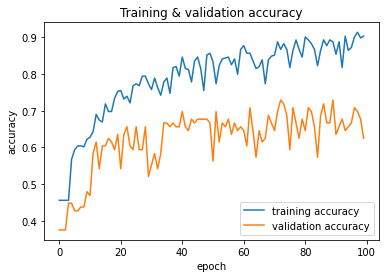

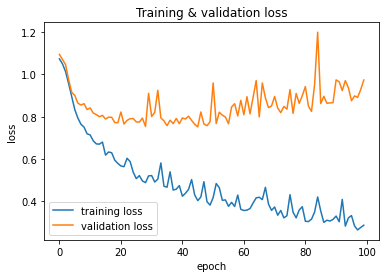

In [21]:
simple_model_4 = NN("sigmoid", Nadam(0.01), layer=4, dropout=False, batch_norm=False)

simple_model_4.train(X_train, y_train, X_test, y_test)

simple_model_4.print_report(X_train, y_train, X_test, y_test)

simple_model_4.draw_plots()

# **Dropout Models**

## ***Dropout Model***
**4 layered sigmoid RMSprop**

Epoch 1/100
6/6 - 1s - loss: 1.1785 - accuracy: 0.4557 - val_loss: 1.0955 - val_accuracy: 0.3750 - 723ms/epoch - 121ms/step
Epoch 2/100
6/6 - 0s - loss: 1.0580 - accuracy: 0.4557 - val_loss: 1.0874 - val_accuracy: 0.3750 - 27ms/epoch - 5ms/step
Epoch 3/100
6/6 - 0s - loss: 1.0337 - accuracy: 0.4557 - val_loss: 1.0487 - val_accuracy: 0.3750 - 29ms/epoch - 5ms/step
Epoch 4/100
6/6 - 0s - loss: 0.9880 - accuracy: 0.4583 - val_loss: 1.0132 - val_accuracy: 0.4062 - 32ms/epoch - 5ms/step
Epoch 5/100
6/6 - 0s - loss: 0.9270 - accuracy: 0.5677 - val_loss: 0.9779 - val_accuracy: 0.4375 - 40ms/epoch - 7ms/step
Epoch 6/100
6/6 - 0s - loss: 0.8800 - accuracy: 0.5807 - val_loss: 0.9291 - val_accuracy: 0.4479 - 26ms/epoch - 4ms/step
Epoch 7/100
6/6 - 0s - loss: 0.8195 - accuracy: 0.5938 - val_loss: 0.9087 - val_accuracy: 0.4271 - 29ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.8097 - accuracy: 0.5885 - val_loss: 0.8833 - val_accuracy: 0.4375 - 31ms/epoch - 5ms/step
Epoch 9/100
6/6 - 0s - loss: 

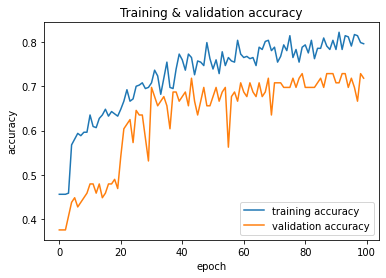

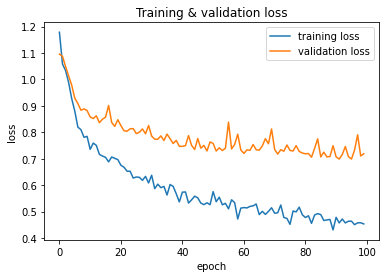

In [22]:
dropout_model_1 = NN("sigmoid", RMSprop(InverseTimeDecay(0.01, 300, 0.9)), layer=4, dropout=True, batch_norm=False)

dropout_model_1.train(X_train, y_train, X_test, y_test)

dropout_model_1.print_report(X_train, y_train, X_test, y_test)

dropout_model_1.draw_plots()

## ***Dropout Model***
**5 layered sigmoid Adam**

Epoch 1/100
6/6 - 1s - loss: 1.1218 - accuracy: 0.3385 - val_loss: 1.1290 - val_accuracy: 0.3750 - 938ms/epoch - 156ms/step
Epoch 2/100
6/6 - 0s - loss: 1.0678 - accuracy: 0.4557 - val_loss: 1.1273 - val_accuracy: 0.3750 - 41ms/epoch - 7ms/step
Epoch 3/100
6/6 - 0s - loss: 1.0612 - accuracy: 0.4557 - val_loss: 1.0911 - val_accuracy: 0.3750 - 34ms/epoch - 6ms/step
Epoch 4/100
6/6 - 0s - loss: 1.0456 - accuracy: 0.4557 - val_loss: 1.0630 - val_accuracy: 0.3750 - 30ms/epoch - 5ms/step
Epoch 5/100
6/6 - 0s - loss: 1.0157 - accuracy: 0.4557 - val_loss: 1.0383 - val_accuracy: 0.3750 - 28ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.9826 - accuracy: 0.4714 - val_loss: 0.9945 - val_accuracy: 0.3750 - 29ms/epoch - 5ms/step
Epoch 7/100
6/6 - 0s - loss: 0.9422 - accuracy: 0.5547 - val_loss: 0.9753 - val_accuracy: 0.4271 - 29ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.9017 - accuracy: 0.5911 - val_loss: 0.9385 - val_accuracy: 0.4479 - 34ms/epoch - 6ms/step
Epoch 9/100
6/6 - 0s - loss: 

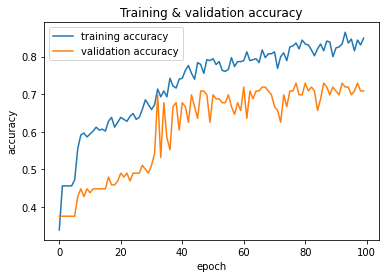

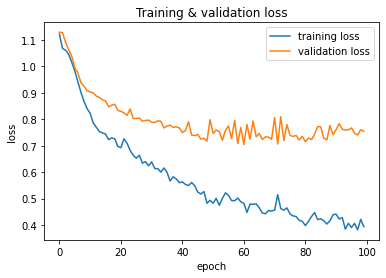

In [23]:
dropout_model_2 = NN("sigmoid", Adam(InverseTimeDecay(0.01, 300, 0.9)), layer=5, dropout=True, batch_norm=False)

dropout_model_2.train(X_train, y_train, X_test, y_test)

dropout_model_2.print_report(X_train, y_train, X_test, y_test)

dropout_model_2.draw_plots()

## ***Dropout Model***
**5 layered tanh Nadam**

Epoch 1/100
6/6 - 1s - loss: 1.0744 - accuracy: 0.4453 - val_loss: 0.9268 - val_accuracy: 0.5000 - 1s/epoch - 215ms/step
Epoch 2/100
6/6 - 0s - loss: 0.8904 - accuracy: 0.5677 - val_loss: 0.8959 - val_accuracy: 0.5625 - 29ms/epoch - 5ms/step
Epoch 3/100
6/6 - 0s - loss: 0.8590 - accuracy: 0.5859 - val_loss: 0.8402 - val_accuracy: 0.5833 - 28ms/epoch - 5ms/step
Epoch 4/100
6/6 - 0s - loss: 0.8370 - accuracy: 0.5495 - val_loss: 0.8636 - val_accuracy: 0.5521 - 27ms/epoch - 5ms/step
Epoch 5/100
6/6 - 0s - loss: 0.7772 - accuracy: 0.6068 - val_loss: 0.8436 - val_accuracy: 0.6458 - 31ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.8039 - accuracy: 0.5729 - val_loss: 0.8482 - val_accuracy: 0.5833 - 32ms/epoch - 5ms/step
Epoch 7/100
6/6 - 0s - loss: 0.7320 - accuracy: 0.6042 - val_loss: 0.8519 - val_accuracy: 0.5729 - 31ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.7397 - accuracy: 0.5833 - val_loss: 0.8570 - val_accuracy: 0.5833 - 28ms/epoch - 5ms/step
Epoch 9/100
6/6 - 0s - loss: 0.7

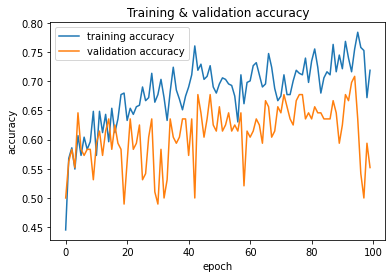

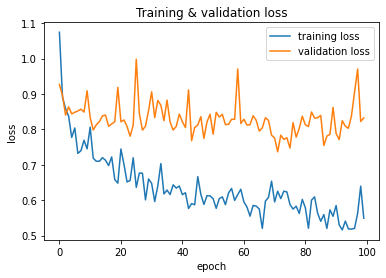

In [24]:
dropout_model_3 = NN("tanh", Nadam(0.01), layer=5, dropout=True, batch_norm=False)

dropout_model_3.train(X_train, y_train, X_test, y_test)

dropout_model_3.print_report(X_train, y_train, X_test, y_test)

dropout_model_3.draw_plots()

## ***Dropout Model***
**5 layered sigmoid Nadam**

Epoch 1/100
6/6 - 1s - loss: 1.1012 - accuracy: 0.3854 - val_loss: 1.1225 - val_accuracy: 0.3750 - 1s/epoch - 210ms/step
Epoch 2/100
6/6 - 0s - loss: 1.0559 - accuracy: 0.4557 - val_loss: 1.0854 - val_accuracy: 0.3750 - 33ms/epoch - 6ms/step
Epoch 3/100
6/6 - 0s - loss: 1.0169 - accuracy: 0.4557 - val_loss: 1.0296 - val_accuracy: 0.3750 - 41ms/epoch - 7ms/step
Epoch 4/100
6/6 - 0s - loss: 0.9682 - accuracy: 0.4844 - val_loss: 0.9812 - val_accuracy: 0.4688 - 34ms/epoch - 6ms/step
Epoch 5/100
6/6 - 0s - loss: 0.9067 - accuracy: 0.5677 - val_loss: 0.9306 - val_accuracy: 0.4479 - 35ms/epoch - 6ms/step
Epoch 6/100
6/6 - 0s - loss: 0.8500 - accuracy: 0.5964 - val_loss: 0.9122 - val_accuracy: 0.4375 - 32ms/epoch - 5ms/step
Epoch 7/100
6/6 - 0s - loss: 0.8173 - accuracy: 0.5990 - val_loss: 0.8856 - val_accuracy: 0.4792 - 33ms/epoch - 6ms/step
Epoch 8/100
6/6 - 0s - loss: 0.8025 - accuracy: 0.5990 - val_loss: 0.8823 - val_accuracy: 0.4583 - 30ms/epoch - 5ms/step
Epoch 9/100
6/6 - 0s - loss: 0.7

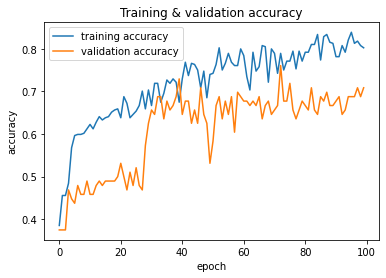

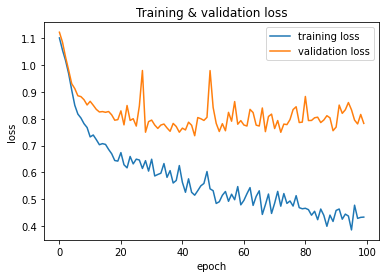

In [25]:
dropout_model_4 = NN("sigmoid", Nadam(0.01), layer=5, dropout=True, batch_norm=False)

dropout_model_4.train(X_train, y_train, X_test, y_test)

dropout_model_4.print_report(X_train, y_train, X_test, y_test)

dropout_model_4.draw_plots()

# **BatchNorm Models**

## ***Batch Norm Model***
**5 layered Relu SGD**

Epoch 1/100
6/6 - 1s - loss: 1.1732 - accuracy: 0.4453 - val_loss: 1.2076 - val_accuracy: 0.4167 - 1s/epoch - 174ms/step
Epoch 2/100
6/6 - 0s - loss: 1.1410 - accuracy: 0.4375 - val_loss: 1.0791 - val_accuracy: 0.3542 - 28ms/epoch - 5ms/step
Epoch 3/100
6/6 - 0s - loss: 1.0293 - accuracy: 0.4870 - val_loss: 1.0406 - val_accuracy: 0.3958 - 32ms/epoch - 5ms/step
Epoch 4/100
6/6 - 0s - loss: 0.9973 - accuracy: 0.5625 - val_loss: 1.0421 - val_accuracy: 0.4271 - 38ms/epoch - 6ms/step
Epoch 5/100
6/6 - 0s - loss: 0.9661 - accuracy: 0.5495 - val_loss: 1.0313 - val_accuracy: 0.4688 - 29ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.9399 - accuracy: 0.5729 - val_loss: 1.0059 - val_accuracy: 0.5104 - 28ms/epoch - 5ms/step
Epoch 7/100
6/6 - 0s - loss: 0.9132 - accuracy: 0.6224 - val_loss: 1.0089 - val_accuracy: 0.5312 - 29ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.9050 - accuracy: 0.6042 - val_loss: 1.0210 - val_accuracy: 0.4583 - 32ms/epoch - 5ms/step
Epoch 9/100
6/6 - 0s - loss: 0.8

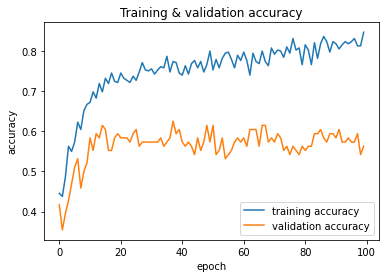

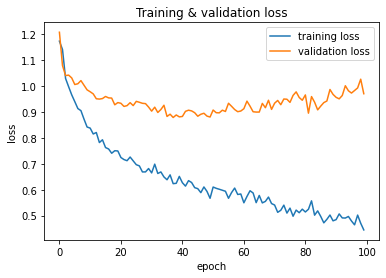

In [26]:
batch_norm_model_1 = NN("relu", SGD(InverseTimeDecay(0.01, 1000, 0.9)), layer=5, dropout=False, batch_norm=True)

batch_norm_model_1.train(X_train, y_train, X_test, y_test)

batch_norm_model_1.print_report(X_train, y_train, X_test, y_test)

batch_norm_model_1.draw_plots()

## ***Batch Norm Model***
**5 layered sigmoid RMSprop**

Epoch 1/100
6/6 - 2s - loss: 0.9768 - accuracy: 0.5208 - val_loss: 1.1073 - val_accuracy: 0.4167 - 2s/epoch - 329ms/step
Epoch 2/100
6/6 - 0s - loss: 0.7857 - accuracy: 0.6042 - val_loss: 1.0769 - val_accuracy: 0.4062 - 33ms/epoch - 5ms/step
Epoch 3/100
6/6 - 0s - loss: 0.7475 - accuracy: 0.6276 - val_loss: 1.0642 - val_accuracy: 0.4062 - 33ms/epoch - 6ms/step
Epoch 4/100
6/6 - 0s - loss: 0.6992 - accuracy: 0.6875 - val_loss: 1.0603 - val_accuracy: 0.3750 - 38ms/epoch - 6ms/step
Epoch 5/100
6/6 - 0s - loss: 0.6865 - accuracy: 0.6823 - val_loss: 1.0559 - val_accuracy: 0.4479 - 32ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.6619 - accuracy: 0.6771 - val_loss: 1.0555 - val_accuracy: 0.3750 - 32ms/epoch - 5ms/step
Epoch 7/100
6/6 - 0s - loss: 0.6554 - accuracy: 0.6536 - val_loss: 1.0546 - val_accuracy: 0.3750 - 30ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.6053 - accuracy: 0.7005 - val_loss: 1.0551 - val_accuracy: 0.3750 - 34ms/epoch - 6ms/step
Epoch 9/100
6/6 - 0s - loss: 0.5

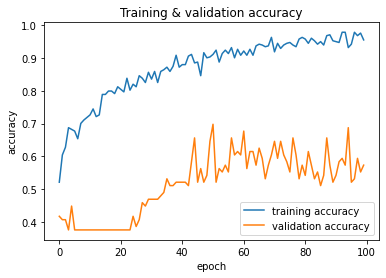

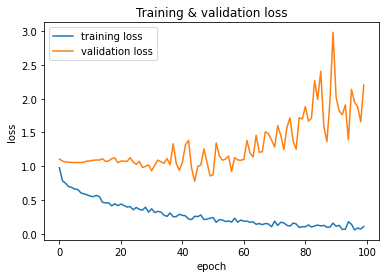

In [27]:
batch_norm_model_2 = NN("sigmoid", RMSprop(InverseTimeDecay(0.01, 300, 0.9)), layer=5, dropout=False, batch_norm=True)

batch_norm_model_2.train(X_train, y_train, X_test, y_test)

batch_norm_model_2.print_report(X_train, y_train, X_test, y_test)

batch_norm_model_2.draw_plots()

## ***Batch Norm Model***
**5 layered sigmoid Adam**

Epoch 1/100
6/6 - 1s - loss: 0.9945 - accuracy: 0.5260 - val_loss: 1.1092 - val_accuracy: 0.4062 - 1s/epoch - 228ms/step
Epoch 2/100
6/6 - 0s - loss: 0.8241 - accuracy: 0.6120 - val_loss: 1.0801 - val_accuracy: 0.4062 - 35ms/epoch - 6ms/step
Epoch 3/100
6/6 - 0s - loss: 0.7526 - accuracy: 0.6380 - val_loss: 1.0651 - val_accuracy: 0.4062 - 35ms/epoch - 6ms/step
Epoch 4/100
6/6 - 0s - loss: 0.7106 - accuracy: 0.6667 - val_loss: 1.0578 - val_accuracy: 0.4062 - 41ms/epoch - 7ms/step
Epoch 5/100
6/6 - 0s - loss: 0.6568 - accuracy: 0.6823 - val_loss: 1.0612 - val_accuracy: 0.5312 - 33ms/epoch - 5ms/step
Epoch 6/100
6/6 - 0s - loss: 0.6044 - accuracy: 0.7266 - val_loss: 1.0762 - val_accuracy: 0.3750 - 33ms/epoch - 6ms/step
Epoch 7/100
6/6 - 0s - loss: 0.6011 - accuracy: 0.7396 - val_loss: 1.0845 - val_accuracy: 0.3750 - 31ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.5767 - accuracy: 0.7344 - val_loss: 1.0996 - val_accuracy: 0.3750 - 40ms/epoch - 7ms/step
Epoch 9/100
6/6 - 0s - loss: 0.5

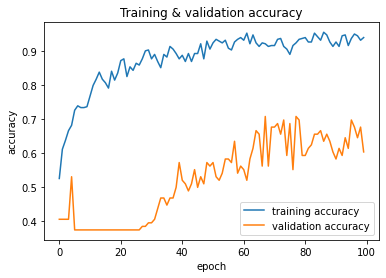

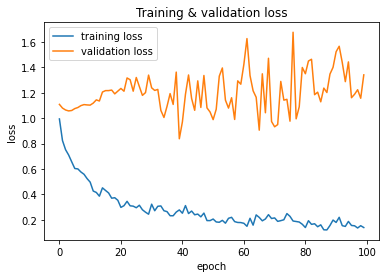

In [29]:
batch_norm_model_3 = NN("sigmoid", Adam(InverseTimeDecay(0.01, 1000, 0.9)), layer=5, dropout=False, batch_norm=True)

batch_norm_model_3.train(X_train, y_train, X_test, y_test)

batch_norm_model_3.print_report(X_train, y_train, X_test, y_test)

batch_norm_model_3.draw_plots()

## ***Batch Norm Model***
**5 layered sigmoid Nadam**

Epoch 1/100
6/6 - 2s - loss: 0.9650 - accuracy: 0.4974 - val_loss: 1.4202 - val_accuracy: 0.3750 - 2s/epoch - 361ms/step
Epoch 2/100
6/6 - 0s - loss: 0.7903 - accuracy: 0.6354 - val_loss: 1.4323 - val_accuracy: 0.3750 - 36ms/epoch - 6ms/step
Epoch 3/100
6/6 - 0s - loss: 0.7207 - accuracy: 0.6745 - val_loss: 1.4630 - val_accuracy: 0.3750 - 31ms/epoch - 5ms/step
Epoch 4/100
6/6 - 0s - loss: 0.6868 - accuracy: 0.6693 - val_loss: 1.4633 - val_accuracy: 0.3750 - 35ms/epoch - 6ms/step
Epoch 5/100
6/6 - 0s - loss: 0.6771 - accuracy: 0.6745 - val_loss: 1.4796 - val_accuracy: 0.3750 - 35ms/epoch - 6ms/step
Epoch 6/100
6/6 - 0s - loss: 0.5943 - accuracy: 0.7214 - val_loss: 1.5202 - val_accuracy: 0.3750 - 37ms/epoch - 6ms/step
Epoch 7/100
6/6 - 0s - loss: 0.5828 - accuracy: 0.7370 - val_loss: 1.5596 - val_accuracy: 0.3750 - 32ms/epoch - 5ms/step
Epoch 8/100
6/6 - 0s - loss: 0.5739 - accuracy: 0.7344 - val_loss: 1.5626 - val_accuracy: 0.3750 - 37ms/epoch - 6ms/step
Epoch 9/100
6/6 - 0s - loss: 0.5

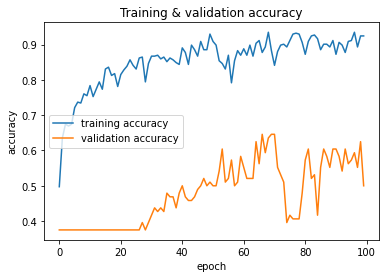

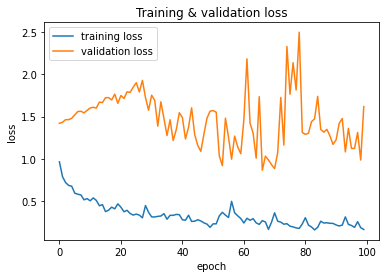

In [30]:
batch_norm_model_4 = NN("sigmoid", Nadam(0.01), layer=5, dropout=False, batch_norm=True)

batch_norm_model_4.train(X_train, y_train, X_test, y_test)

batch_norm_model_4.print_report(X_train, y_train, X_test, y_test)

batch_norm_model_4.draw_plots()

# ***K-fold Cross Validator***
**batch norm 5 layered sigmoid RMSprop**

In [31]:
K_fold_cross_val(X, y, k=5, model_type="batch_norm", activation = "sigmoid", optimizer=RMSprop(InverseTimeDecay(0.01, 300, 0.9)), layer=5)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss = 1.7436977624893188 ------ accuuracy = 58.33333134651184%
[[21  6  0]
 [11 30  3]
 [ 2 18  5]]
              precision    recall  f1-score   support

         Low       0.62      0.78      0.69        27
      Medium       0.56      0.68      0.61        44
        High       0.62      0.20      0.30        25

   micro avg       0.58      0.58      0.58        96
   macro avg       0.60      0.55      0.53        96
weighted avg       0.59      0.58      0.55        96
 samples avg       0.58      0.58      0.58        96

------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss = 1.1865204572677612 ------ accuuracy = 68.75%
[[16  5  2]
 [ 4 24 12]
 [ 0  7 26]]
              precision    recall  f1-score   support

         Low       0.80      0.70      0.74        23
      Medium       0.67      0.60   

# ***K-fold Cross Validator***
**batch norm 5 layered sigmoid Adam**

In [32]:
K_fold_cross_val(X, y, k=5, model_type="batch_norm", activation = "sigmoid", optimizer=Adam(InverseTimeDecay(0.01, 1000, 0.9)), layer=5)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss = 1.42893648147583 ------ accuuracy = 69.79166865348816%
[[16  8  0]
 [ 5 37  4]
 [ 0 12 14]]
              precision    recall  f1-score   support

         Low       0.76      0.67      0.71        24
      Medium       0.65      0.80      0.72        46
        High       0.78      0.54      0.64        26

   micro avg       0.70      0.70      0.70        96
   macro avg       0.73      0.67      0.69        96
weighted avg       0.71      0.70      0.69        96
 samples avg       0.70      0.70      0.70        96

------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss = 1.5087212324142456 ------ accuuracy = 62.5%
[[21  8  1]
 [ 4 26 13]
 [ 0 10 13]]
              precision    recall  f1-score   support

         Low       0.84      0.70      0.76        30
      Medium       0.59      0.60      

# ***K-fold Cross Validator***
**batch norm 5 layered sigmoid Nadam**

In [33]:
K_fold_cross_val(X, y, k=5, model_type="batch_norm", activation = "sigmoid", optimizer=Nadam(0.01), layer=5)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss = 1.4657038450241089 ------ accuuracy = 57.29166865348816%
[[19  3  1]
 [ 5 17 29]
 [ 0  3 19]]
              precision    recall  f1-score   support

         Low       0.79      0.83      0.81        23
      Medium       0.74      0.33      0.46        51
        High       0.39      0.86      0.54        22

   micro avg       0.57      0.57      0.57        96
   macro avg       0.64      0.67      0.60        96
weighted avg       0.67      0.57      0.56        96
 samples avg       0.57      0.57      0.57        96

------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss = 1.0104984045028687 ------ accuuracy = 68.75%
[[16  4  1]
 [ 4 27 16]
 [ 0  5 23]]
              precision    recall  f1-score   support

         Low       0.80      0.76      0.78        21
      Medium       0.75      0.57   